# Addict Recovery Journey Recommender (Audio + Transcript)

### Cell 0 — Setup: paths, installs, imports, and small utility functions

This cell:
- Defines folder paths (to your CSV and audio directory).
- Suggests pip installs (commented out) — run them once as needed.
- Imports all libraries.
- Implements small helpers: JSON save/load, JSD, DTW, and plotting colors.

If some optional libraries (e.g., `bertopic`, `whisper`) are not present, the code gracefully falls back to simpler logic (KMeans for topics; basic ASR error with instructions).


In [ ]:
# -----------------------------
# Recommended pip installs (run once in your environment; then comment them out)
# -----------------------------
# !pip install pandas numpy matplotlib networkx scikit-learn scipy tqdm
# !pip install sentence-transformers spacy
# !python -m spacy download en_core_web_sm
# !pip install transformers torch torchaudio --upgrade
# Optional (preferred for topics): 
# !pip install bertopic umap-learn hdbscan
# Optional (preferred for ASR):
# !pip install openai-whisper
# Optional (audio features):
# !pip install librosa soundfile

import os
import json
import math
import glob
import warnings
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx

# Embeddings & NLP
from sentence_transformers import SentenceTransformer
import spacy

# ML
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Viz
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx

# Distances
from scipy.spatial.distance import jensenshannon

# Sentiment
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Optional imports with fallbacks
try:
    from bertopic import BERTopic
    _HAS_BERTOPIC = True
except Exception:
    _HAS_BERTOPIC = False

try:
    import whisper
    _HAS_WHISPER = True
except Exception:
    _HAS_WHISPER = False

try:
    import librosa
    import soundfile as sf
    _HAS_LIBROSA = True
except Exception:
    _HAS_LIBROSA = False
    warnings.warn("librosa/soundfile not found: audio features will be limited.")

# -----------------------------
# Paths — adjust to your environment
# -----------------------------
DATA_DIR_TRANSCRIPT = Path("./Final Dataset/transcript")  # change if needed
TRANSCRIPTS_CSV = DATA_DIR_TRANSCRIPT / "playlist_transcripts_complete.csv"
DATA_DIR_AUDIO = Path("./Final Dataset/audio")  # change if needed
AUDIO_DIR = DATA_DIR_AUDIO          # your .m4a files live here
OUT_DIR = Path("./results")   # where outputs (JSON/PNG) will be written
OUT_DIR.mkdir(parents=True, exist_ok=True)
MINDMAP_DIR = OUT_DIR / "mindmaps"
MINDMAP_DIR.mkdir(parents=True, exist_ok=True)
BASELINE_DIR = OUT_DIR / "baselines"
BASELINE_DIR.mkdir(parents=True, exist_ok=True)

# -----------------------------
# Stage ontology & seeds
# -----------------------------
STAGES = [
    "Denial",              # Pre-contemplation / denial
    "Ambivalence",         # Contemplation
    "Commitment",          # Preparation / commitment
    "Coping",              # Early action / coping skills
    "Maintenance",         # Maintenance / support
    "Relapse"              # Lapse / relapse / re-engagement
]

STAGE_SEEDS = {
    "Denial": ["not a problem", "i'm fine", "others exaggerate", "no issue", "it’s under control"],
    "Ambivalence": ["conflicted", "mixed feelings", "want to stop", "but", "unsure", "struggle"],
    "Commitment": ["plan", "decided", "commit", "seeking help", "treatment", "intent"],
    "Coping": ["urges", "triggers", "skills", "sponsor", "meetings", "therapy", "coping"],
    "Maintenance": ["routine", "support", "boundary", "avoid triggers", "stability", "sober"],
    "Relapse": ["slipped", "relapse", "drank again", "used again", "reset", "regret", "back on track"]
}

# -----------------------------
# Utility helpers
# -----------------------------
def save_json(obj, path: Path):
    """Save a Python object as formatted JSON."""
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2)

def load_json(path: Path):
    """Load JSON into Python dict."""
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def js_divergence(p, q, eps=1e-12):
    """
    Jensen-Shannon divergence between two distributions p and q.
    p, q are arrays that sum to 1.
    Returns: float in [0, 1], lower is more similar.
    """
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    p = p / max(p.sum(), eps)
    q = q / max(q.sum(), eps)
    return float(jensenshannon(p, q, base=2.0))  # 0..1

def dtw_distance(seq_a, seq_b):
    """
    Simple DTW distance between two integer sequences (stage indices).
    """
    n, m = len(seq_a), len(seq_b)
    dp = np.full((n+1, m+1), np.inf)
    dp[0, 0] = 0.0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = 0.0 if seq_a[i-1] == seq_b[j-1] else 1.0
            dp[i, j] = cost + min(dp[i-1, j], dp[i, j-1], dp[i-1, j-1])
    return float(dp[n, m])

def sentiment_to_color(sent):
    """
    Map sentiment in [-1, 1] to a color hex using RdYlGn (green=positive).
    """
    cmap = plt.get_cmap("RdYlGn")
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    return mcolors.to_hex(cmap(norm(sent)))

# -----------------------------------------------------------
# 1️⃣ build_stage_graph
# -----------------------------------------------------------
def build_stage_graph(stage_stats: dict) -> nx.DiGraph:
    """
    Convert a dictionary of stage-level stats into a directed graph.

    Parameters
    ----------
    stage_stats : dict
        {stage_name: {'time_share': float,
                      'avg_sentiment': float,
                      'lift': float,
                      'transitions': {target_stage: prob, ...}}}

    Returns
    -------
    nx.DiGraph
        NetworkX graph object with node and edge attributes.
    """
    G = nx.DiGraph()
    for stage, info in stage_stats.items():
        G.add_node(
            stage,
            time_share=info.get("time_share", 0.0),
            sentiment=info.get("avg_sentiment", 0.0),
            lift=info.get("lift", 1.0)
        )
        for tgt, w in info.get("transitions", {}).items():
            if w > 0:
                G.add_edge(stage, tgt, weight=w)
    return G


# -----------------------------------------------------------
# 2️⃣ sentiment_to_color (utility)
# -----------------------------------------------------------
def sentiment_to_color(sentiment_value: float) -> str:
    """
    Map sentiment value [-1, 1] → color (green to red).
    """
    cmap = plt.get_cmap("RdYlGn")
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    return mcolors.to_hex(cmap(norm(sentiment_value)))


# -----------------------------------------------------------
# 3️⃣ plot_stage_mindmap
# -----------------------------------------------------------
def plot_stage_mindmap(G: nx.DiGraph, title: str, output_path: Path):
    """
    Visualize and save the stage mind-map as a PNG image.
    - Node size ∝ time_share
    - Node color ∝ sentiment
    - Edge width ∝ transition probability
    """
    plt.figure(figsize=(9, 7))
    pos = nx.spring_layout(G, seed=42, k=0.8)

    # Node visuals
    sizes = [max(100, G.nodes[n]['time_share'] * 4000) for n in G.nodes()]
    colors = [sentiment_to_color(G.nodes[n]['sentiment']) for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors, alpha=0.9)

    # Edge visuals
    weights = [G[u][v]['weight'] * 5.0 for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=weights, alpha=0.4, arrows=True)

    # Node labels: show time%, sentiment%, lift
    labels = {
        n: f"{n}\n{G.nodes[n]['time_share'] * 100:.1f}% | "
           f"Sent {G.nodes[n]['sentiment'] * 100:.0f}% | "
           f"Lift {G.nodes[n]['lift']:.2f}"
        for n in G.nodes()
    }
    nx.draw_networkx_labels(G, pos, labels, font_size=8)

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.close()


# -----------------------------------------------------------
# 4️⃣ save_graph_json
# -----------------------------------------------------------
def save_graph_json(G: nx.DiGraph, output_path: Path):
    """
    Save the graph structure (nodes + edges) as a JSON file for later use.
    """
    data = nx.node_link_data(G)
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2)


print("✅ Setup complete. BERTopic:", _HAS_BERTOPIC, "| Whisper:", _HAS_WHISPER, "| Librosa:", _HAS_LIBROSA)


✅ Setup complete. BERTopic: False | Whisper: True | Librosa: True


### Cell A — Normalize transcripts (utterance-level) and basic cleaning

This cell:
- Loads your `playlist_transcripts_complete.csv`.
- Uses the actual column names in your dataset:
  - `video_id` → the unique YouTube ID  
  - `transcript_whisper` → the transcript text
  - `title` → optional video title
- Creates a canonical schema: `video_id, text, start_time, end_time, title`
- Splits long transcript paragraphs into individual sentences (spaCy)
  so that later NLP steps (embeddings, topics, sentiment) work better.

> Printouts: shows basic shape and head.

**BEFORE RUNNING, CHECK FOR `./results/dataframes/df_text.csv` FILE. IF THE FILE IS PRESENT, DO NOT RUN BELOW CELL AND GO TO NEXT CELL.**

In [2]:
# -----------------------------
# Load transcripts CSV
# -----------------------------
df = pd.read_csv(TRANSCRIPTS_CSV)

# -----------------------------
# Manual column mapping (based on your CSV header)
# -----------------------------
colmap = {
    "video_id": "video_id",            # unique video identifier
    "text": "transcript_whisper",      # transcript text column
    "start_time": None,                # not present yet
    "end_time": None,                  # not present yet
    "title": "title"                   # optional metadata
}

# -----------------------------
# Build normalized dataframe
# -----------------------------
df_text = pd.DataFrame({
    "video_id": df[colmap["video_id"]].astype(str),
    "text": df[colmap["text"]].astype(str),
    "start_time": np.nan,   # placeholder until we align with audio
    "end_time": np.nan,
    "title": df[colmap["title"]].astype(str) if colmap["title"] else ""
})

# -----------------------------
# Split long paragraphs into sentences (spaCy)
# -----------------------------
nlp = spacy.load("en_core_web_sm")

rows = []
for _, row in df_text.iterrows():
    text = (row["text"] or "").strip()
    if not text:
        continue
    # If paragraph is long, break into sentences
    if len(text) > 300:
        doc = nlp(text)
        for sent in doc.sents:
            s = sent.text.strip()
            if s:
                rows.append({
                    "video_id": row["video_id"],
                    "text": s,
                    "start_time": np.nan,
                    "end_time": np.nan,
                    "title": row["title"]
                })
    else:
        rows.append(row.to_dict())

# Create final utterance-level dataframe
df_text = pd.DataFrame(rows).reset_index(drop=True)

print("✅ Transcript normalization complete.")
print("Number of rows:", len(df_text))
print(df_text.head(5))


✅ Transcript normalization complete.
Number of rows: 10090
      video_id                                               text  start_time  \
0  -GhhcZUYmMk  So I started using drugs when I was 12 years old.         NaN   
1  -GhhcZUYmMk  Really I just wanted to fit in with everyone, ...         NaN   
2  -GhhcZUYmMk  I was this hippie chick, I was going to fish s...         NaN   
3  -GhhcZUYmMk  I had a lot of freedom growing up as a child, ...         NaN   
4  -GhhcZUYmMk  and I really had very, very, very low self-est...         NaN   

   end_time                       title  
0       NaN  Recovery - Honesty's Story  
1       NaN  Recovery - Honesty's Story  
2       NaN  Recovery - Honesty's Story  
3       NaN  Recovery - Honesty's Story  
4       NaN  Recovery - Honesty's Story  


### Cell B — Audio Path (ASR timestamps + audio features + SER proxy)

This cell:
- Collects all `.m4a` files from `AUDIO_DIR`.
- Transcribes with Whisper (if installed) to get **ASR segments** with timestamps.
  - If Whisper is not installed, it raises a clear message.
- Extracts basic audio features (if `librosa` is available): duration, RMS energy, pitch proxy.
- Produces a per-segment table: `df_audio_segs` containing
  `video_id, seg_id, start_time, end_time, asr_text, energy, pitch_proxy`.
- Computes a **SER proxy valence** in [-1, 1] using normalized energy and pitch as a simple stand-in.

> Printouts: number of audio files, and a preview of the segment table.


**BEFORE RUNNING, CHECK FOR `./results/dataframes/df_audio_segs.csv` FILE. IF THE FILE IS PRESENT, DO NOT RUN BELOW CELL AND GO TO NEXT CELL.**

In [6]:
# Collect all .m4a files
audio_files = sorted(glob.glob(str(AUDIO_DIR / "*.m4a")))
print(f"Found {len(audio_files)} audio files.")

if not _HAS_WHISPER:
    raise RuntimeError("Whisper (openai-whisper) not installed. Please `pip install openai-whisper` "
                       "or skip ASR here and later align transcript-only.")

# Load Whisper model (tiny/base/small/medium/large; 'small' is a good tradeoff)
whisper_model = whisper.load_model("small")

audio_segments = []  # list of dicts: video_id, seg_id, start_time, end_time, asr_text, energy, pitch_proxy

for a_path in tqdm(audio_files, desc="ASR & features"):
    vid = Path(a_path).stem  # assume filename is YouTube ID
    # --- ASR with timestamps
    result = whisper_model.transcribe(a_path, verbose=False)
    segs = result.get("segments", [])
    
    # If librosa available, load audio for simple feature summaries
    y, sr = (None, None)
    if _HAS_LIBROSA:
        y, sr = librosa.load(a_path, sr=None, mono=True)
    
    for s in segs:
        seg_id = s['id']
        start_t = float(s['start'])
        end_t = float(s['end'])
        asr_text = s.get('text', '').strip()

        # Extract energy and a pitch proxy for this segment if librosa is present
        energy = None
        pitch_proxy = None
        if _HAS_LIBROSA and y is not None:
            # Get samples corresponding to this segment
            i0 = max(0, int(start_t * sr))
            i1 = min(len(y), int(end_t * sr))
            seg_y = y[i0:i1] if i1 > i0 else None
            if seg_y is not None and seg_y.size > 0:
                # Energy (RMS)
                energy = float(np.sqrt(np.mean(seg_y**2)))
                # Pitch proxy via spectral centroid (it's NOT true F0 but a weak proxy)
                S, phase = librosa.magphase(librosa.stft(seg_y, n_fft=1024, hop_length=256))
                spec_centroid = librosa.feature.spectral_centroid(S=S, sr=sr).mean()
                # Normalize to ~[0,1] by dividing by Nyquist
                pitch_proxy = float(min(1.0, spec_centroid / (sr/2)))
        
        audio_segments.append({
            'video_id': vid,
            'seg_id': seg_id,
            'start_time': start_t,
            'end_time': end_t,
            'asr_text': asr_text,
            'energy': energy,
            'pitch_proxy': pitch_proxy
        })

df_audio_segs = pd.DataFrame(audio_segments)

# Simple SER proxy: valence ~ scaled energy + scaled pitch_proxy (both z-scored then tanh)
for col in ['energy', 'pitch_proxy']:
    if col in df_audio_segs and df_audio_segs[col].notna().any():
        vals = df_audio_segs[col].fillna(df_audio_segs[col].mean())
        z = (vals - vals.mean()) / (vals.std() + 1e-6)
        df_audio_segs[col + "_z"] = z
    else:
        df_audio_segs[col + "_z"] = 0.0

# map to [-1,1]
df_audio_segs['valence_audio'] = np.tanh(0.7*df_audio_segs['energy_z'] + 0.3*df_audio_segs['pitch_proxy_z'])
print("✅ Audio segments with SER proxy ready. Shape:", df_audio_segs.shape)
print(df_audio_segs.head(8))


Found 51 audio files.


ASR & features:   0%|          | 0/51 [00:00<?, ?it/s]

Detected language: English


 99%|█████████▊| 116516/118087 [08:10<00:06, 237.68frames/s]
C:\Users\Abhiroop Kumar\AppData\Local\Temp\ipykernel_9336\3451713617.py:23: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(a_path, sr=None, mono=True)
c:\Users\Abhiroop Kumar\miniconda3\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
ASR & features:   2%|▏         | 1/51 [09:09<7:37:55, 549.52s/it]c:\Users\Abhiroop Kumar\miniconda3\Lib\site-packages\whisper\transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Detected language: English


100%|██████████| 87838/87838 [05:47<00:00, 253.01frames/s]
C:\Users\Abhiroop Kumar\AppData\Local\Temp\ipykernel_9336\3451713617.py:23: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(a_path, sr=None, mono=True)
c:\Users\Abhiroop Kumar\miniconda3\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
ASR & features:   4%|▍         | 2/51 [15:17<6:01:25, 442.57s/it]

Detected language: English


ASR & features:   6%|▌         | 3/51 [23:10<6:05:23, 456.74s/it]

Detected language: English


ASR & features:   8%|▊         | 4/51 [32:59<6:38:30, 508.72s/it]

Detected language: English


ASR & features:  10%|▉         | 5/51 [36:42<5:11:03, 405.73s/it]

Detected language: English


ASR & features:  12%|█▏        | 6/51 [41:55<4:40:41, 374.24s/it]

Detected language: English


ASR & features:  14%|█▎        | 7/51 [54:55<6:11:38, 506.78s/it]

Detected language: English


ASR & features:  16%|█▌        | 8/51 [58:21<4:54:34, 411.04s/it]

Detected language: English


ASR & features:  18%|█▊        | 9/51 [1:04:16<4:35:33, 393.66s/it]

Detected language: English


ASR & features:  20%|█▉        | 10/51 [1:15:06<5:23:08, 472.90s/it]

Detected language: English


ASR & features:  22%|██▏       | 11/51 [1:22:45<5:12:16, 468.42s/it]

Detected language: English


ASR & features:  24%|██▎       | 12/51 [1:38:32<6:39:07, 614.03s/it]

Detected language: English


ASR & features:  25%|██▌       | 13/51 [1:44:33<5:40:25, 537.52s/it]

Detected language: English


ASR & features:  27%|██▋       | 14/51 [1:55:06<5:49:17, 566.41s/it]

Detected language: English


ASR & features:  29%|██▉       | 15/51 [2:03:08<5:24:35, 540.98s/it]

Detected language: English


ASR & features:  31%|███▏      | 16/51 [2:12:23<5:17:52, 544.91s/it]

Detected language: English


ASR & features:  33%|███▎      | 17/51 [2:15:40<4:09:34, 440.43s/it]

Detected language: English


ASR & features:  35%|███▌      | 18/51 [2:21:43<3:49:26, 417.18s/it]

Detected language: English


ASR & features:  37%|███▋      | 19/51 [2:27:09<3:27:53, 389.81s/it]

Detected language: English


ASR & features:  39%|███▉      | 20/51 [2:35:05<3:34:47, 415.73s/it]

Detected language: English


ASR & features:  41%|████      | 21/51 [2:41:10<3:20:12, 400.43s/it]

Detected language: English


ASR & features:  43%|████▎     | 22/51 [2:48:55<3:22:55, 419.84s/it]

Detected language: English


ASR & features:  45%|████▌     | 23/51 [2:52:28<2:46:53, 357.62s/it]

Detected language: English


ASR & features:  47%|████▋     | 24/51 [2:58:08<2:38:35, 352.43s/it]

Detected language: English


ASR & features:  49%|████▉     | 25/51 [3:03:39<2:29:55, 345.97s/it]

Detected language: English


ASR & features:  51%|█████     | 26/51 [3:17:26<3:24:17, 490.29s/it]

Detected language: English


ASR & features:  53%|█████▎    | 27/51 [3:33:06<4:10:04, 625.19s/it]

Detected language: English


ASR & features:  55%|█████▍    | 28/51 [3:39:28<3:31:45, 552.41s/it]

Detected language: English


ASR & features:  57%|█████▋    | 29/51 [3:48:54<3:24:00, 556.40s/it]

Detected language: English


ASR & features:  59%|█████▉    | 30/51 [3:54:16<2:50:09, 486.14s/it]

Detected language: English


ASR & features:  61%|██████    | 31/51 [3:59:23<2:24:04, 432.23s/it]

Detected language: English


ASR & features:  63%|██████▎   | 32/51 [4:02:58<1:56:16, 367.16s/it]

Detected language: English


ASR & features:  65%|██████▍   | 33/51 [4:17:32<2:35:47, 519.31s/it]

Detected language: English


ASR & features:  67%|██████▋   | 34/51 [4:21:29<2:03:07, 434.53s/it]

Detected language: English


ASR & features:  69%|██████▊   | 35/51 [4:28:17<1:53:44, 426.54s/it]

Detected language: English


ASR & features:  71%|███████   | 36/51 [4:31:54<1:30:53, 363.55s/it]

Detected language: English


ASR & features:  73%|███████▎  | 37/51 [4:42:18<1:43:06, 441.87s/it]

Detected language: English


ASR & features:  75%|███████▍  | 38/51 [4:51:33<1:43:04, 475.73s/it]

Detected language: English


ASR & features:  76%|███████▋  | 39/51 [4:55:14<1:19:50, 399.22s/it]

Detected language: English


ASR & features:  78%|███████▊  | 40/51 [5:00:44<1:09:23, 378.47s/it]

Detected language: English


ASR & features:  80%|████████  | 41/51 [5:05:45<59:13, 355.37s/it]  

Detected language: English


ASR & features:  82%|████████▏ | 42/51 [5:12:45<56:13, 374.85s/it]

Detected language: English


ASR & features:  84%|████████▍ | 43/51 [5:17:23<46:05, 345.64s/it]

Detected language: English


ASR & features:  86%|████████▋ | 44/51 [5:20:04<33:52, 290.33s/it]

Detected language: English


ASR & features:  88%|████████▊ | 45/51 [5:25:14<29:37, 296.17s/it]

Detected language: English


ASR & features:  90%|█████████ | 46/51 [5:46:37<49:21, 592.28s/it]

Detected language: English


ASR & features:  92%|█████████▏| 47/51 [6:00:10<43:54, 658.58s/it]

Detected language: English


ASR & features:  94%|█████████▍| 48/51 [6:03:50<26:20, 526.95s/it]

Detected language: English


ASR & features:  96%|█████████▌| 49/51 [6:07:59<14:46, 443.40s/it]

Detected language: English


ASR & features:  98%|█████████▊| 50/51 [6:12:46<06:36, 396.56s/it]

Detected language: English


ASR & features: 100%|██████████| 51/51 [6:19:11<00:00, 446.11s/it]


✅ Audio segments with SER proxy ready. Shape: (12096, 10)
      video_id  seg_id  start_time  end_time  \
0  -GhhcZUYmMk       0        0.00     12.40   
1  -GhhcZUYmMk       1       12.40     17.44   
2  -GhhcZUYmMk       2       17.44     19.64   
3  -GhhcZUYmMk       3       19.64     24.44   
4  -GhhcZUYmMk       4       24.44     28.04   
5  -GhhcZUYmMk       5       28.04     32.96   
6  -GhhcZUYmMk       6       32.96     39.44   
7  -GhhcZUYmMk       7       39.44     40.72   

                                            asr_text    energy  pitch_proxy  \
0  So I started using drugs when I was 12 years old.  0.069300     0.035417   
1  Really I just wanted to fit in with everyone, ...  0.124126     0.083994   
2                             a lot of LSD actually.  0.092065     0.093676   
3  I was this hippie chick, I was going to fish s...  0.127893     0.107092   
4                   12, 13, 14 year old does not do.  0.101989     0.101248   
5  I had a lot of freedom growing u

#### Helper Cell — Automatic Save/Load of Processed DataFrames

This optional cell automatically:
- **Saves** df_text and df_audio_segs to `./results/dataframes/` on first run.
- **Loads** them automatically on later runs if the CSVs already exist.

👉 You don’t need to change any variables.  
Just re-run this cell after Cell B, and it will “do the right thing”.


In [2]:
# -----------------------------
# Automatic Save/Load Checkpoint
# -----------------------------
DF_DIR = OUT_DIR / "dataframes"
DF_DIR.mkdir(parents=True, exist_ok=True)

text_path = DF_DIR / "df_text.csv"
audio_path = DF_DIR / "df_audio_segs.csv"

if text_path.exists() and audio_path.exists():
    # --- IMPORT mode ---
    df_text = pd.read_csv(text_path)
    df_audio_segs = pd.read_csv(audio_path)
    mode_used = "import"
    print(f"🔁 Found existing DataFrames in {DF_DIR}. Imported them successfully.")
else:
    # --- EXPORT mode ---
    df_text.to_csv(text_path, index=False)
    df_audio_segs.to_csv(audio_path, index=False)
    mode_used = "export"
    print(f"💾 Saved new DataFrames to {DF_DIR} (first-time export).")

print(f"✅ df_text shape: {df_text.shape}")
print(f"✅ df_audio_segs shape: {df_audio_segs.shape}")
print(f"🟢 Mode used: {mode_used.upper()}")


🔁 Found existing DataFrames in results\dataframes. Imported them successfully.
✅ df_text shape: (10090, 5)
✅ df_audio_segs shape: (12096, 10)
🟢 Mode used: IMPORT


### Cell C — Transcript Path (embeddings, sentiment, topics, stage mapping)

This cell:
- Computes sentence embeddings for transcript utterances (SentenceTransformers).
- Computes a **text valence** proxy in [-1, 1].
  - To keep dependencies light, we’ll use a simple lexicon heuristic as a placeholder (you can swap in VADER or a supervised model easily).
- Performs **topic discovery**:
  - If BERTopic is installed → use it.
  - Else → fallback to MiniBatchKMeans on embeddings.
- **Auto-names** topics with spaCy noun chunks/verbs *excluding* each cluster’s most frequent tokens (to avoid echoing).
- Maps each **micro-topic** to one of the **STAGES** using cosine similarity between the topic centroid and the seed phrases’ embeddings.

Outputs:
- `df_text_enriched`: per-utterance dataframe with `topic_id`, `topic_label`, and `stage_text`.


In [6]:
# -------------- Embeddings --------------
# Load a light, fast model
sbert = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Compute embeddings for utterances
texts = df_text['text'].tolist()
emb = sbert.encode(texts, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)

# -------------- Text sentiment (lightweight placeholder) --------------
# Very simple lexicon-based scoring to keep demo self-contained (swap in VADER for better accuracy)
pos_words = set(["hope", "proud", "grateful", "support", "sober", "recover", "improve", "better", "strong"])
neg_words = set(["shame", "guilt", "relapse", "regret", "crave", "urge", "bad", "worse", "pain", "angry", "sad"])

def simple_valence(s: str):
    tokens = [t.lower() for t in s.split()]
    pos = sum(t in pos_words for t in tokens)
    neg = sum(t in neg_words for t in tokens)
    score = pos - neg
    # squash to [-1,1]
    return float(np.tanh(score / 2.0))

df_text['valence_text'] = df_text['text'].apply(simple_valence)

# -------------- Topic discovery --------------
if _HAS_BERTOPIC:
    topic_model = BERTopic(calculate_probabilities=False, verbose=False)
    topics, probs = topic_model.fit_transform(texts, emb)
    df_text['topic_id'] = topics
    # Use topic_model.get_topic_info() / get_topic() for details
    # We'll generate our own labels via spaCy logic below as requested
else:
    # Fallback: choose K based on sqrt(N)
    K = max(6, int(math.sqrt(len(df_text))))
    kmeans = MiniBatchKMeans(n_clusters=K, random_state=42, batch_size=512)
    topic_ids = kmeans.fit_predict(emb)
    df_text['topic_id'] = topic_ids

print("✅ Topics assigned (BERTopic:", _HAS_BERTOPIC, "). Unique topics:", df_text['topic_id'].nunique())

# -------------- Auto-naming topics with spaCy, excluding top cluster terms --------------
# Build per-topic member lists
topic_groups = df_text.groupby('topic_id')['text'].apply(list).to_dict()

# Build a simple TF for each topic to find top ngrams to exclude
def top_unigrams(texts, topk=10):
    c = Counter()
    for s in texts:
        for t in s.lower().split():
            c[t] += 1
    return set([w for w, _ in c.most_common(topk)])

def spacy_label(texts, exclude: set, nlp_obj, topk=2):
    """
    Extract noun chunks and verbs from the texts, excluding frequent words.
    Return top TF-IDF-like phrases as label.
    """
    # collect candidates
    c = Counter()
    for s in texts:
        doc = nlp_obj(s)
        for chunk in doc.noun_chunks:
            key = chunk.text.strip().lower()
            if key and all(tok not in exclude for tok in key.split()):
                c[key] += 1
        # verbs as single tokens
        for tok in doc:
            if tok.pos_ == "VERB":
                v = tok.lemma_.lower().strip()
                if v and v not in exclude:
                    c[v] += 1
    if not c:
        return "General"
    parts = [w for w, _ in c.most_common(topk)]
    return " / ".join(parts[:topk])

nlp = spacy.load("en_core_web_sm")

topic_labels = {}
for tid, t_texts in topic_groups.items():
    excl = top_unigrams(t_texts, topk=10)
    label = spacy_label(t_texts, excl, nlp, topk=2)
    topic_labels[tid] = label

df_text['topic_label'] = df_text['topic_id'].map(topic_labels)

# -------------- Map topics to stages via seed embedding similarity --------------
# Compute centroid per topic
topic_centroids = {}
for tid, idxs in df_text.groupby('topic_id').indices.items():
    idxs = list(idxs)
    topic_centroids[tid] = emb[idxs].mean(axis=0)

# Build stage seed embeddings
stage_seed_texts = {s: " ; ".join(STAGE_SEEDS[s]) for s in STAGES}
stage_seed_emb = {s: sbert.encode([stage_seed_texts[s]], normalize_embeddings=True)[0] for s in STAGES}

def map_topic_to_stage(tid):
    centroid = topic_centroids[tid].reshape(1, -1)
    sims = []
    for s in STAGES:
        sims.append((s, float(cosine_similarity(centroid, stage_seed_emb[s].reshape(1, -1))[0,0])))
    sims.sort(key=lambda x: x[1], reverse=True)
    return sims[0][0]  # best stage

topic_to_stage = {tid: map_topic_to_stage(tid) for tid in topic_centroids.keys()}
df_text['stage_text'] = df_text['topic_id'].map(topic_to_stage)


# -----------------------------------------------------------
# Sentiment Analysis (adds valence_text to df_text)
# -----------------------------------------------------------

# Download VADER lexicon if not already
nltk.download('vader_lexicon', quiet=True)

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Compute compound sentiment (-1 = negative, +1 = positive)
df_text["valence_text"] = df_text["text"].apply(lambda t: sia.polarity_scores(str(t))["compound"])

print("✅ Added valence_text column to df_text.\n")
print("✅ Transcript path ready. Sample rows:")
print(df_text[['video_id','text','valence_text','topic_id','topic_label','stage_text']].head(8))



Batches:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Topics assigned (BERTopic: False ). Unique topics: 100
✅ Added valence_text column to df_text.

✅ Transcript path ready. Sample rows:
      video_id                                               text  \
0  -GhhcZUYmMk  So I started using drugs when I was 12 years old.   
1  -GhhcZUYmMk  Really I just wanted to fit in with everyone, ...   
2  -GhhcZUYmMk  I was this hippie chick, I was going to fish s...   
3  -GhhcZUYmMk  I had a lot of freedom growing up as a child, ...   
4  -GhhcZUYmMk  and I really had very, very, very low self-est...   
5  -GhhcZUYmMk  So this was kind of my outlet of being able to...   
6  -GhhcZUYmMk  And then when I was 17, that's when I started ...   
7  -GhhcZUYmMk  I used heroin and other opiates, but really sp...   

   valence_text  topic_id topic_label stage_text  
0        0.0000         8  start / it    Relapse  
1        0.3612         2  you / know    Relapse  
2        0.0000         8  start / it    Relapse  
3        0.7096         7   it / know 

### Cell D — Map Audio Segments to Recovery Stages (Audio-Stage Mapping)

This cell assigns each audio segment a recovery stage (`stage_audio`) and an
estimated tone (`valence_audio`).

For now we align audio segments with transcript information (if timestamps overlap),
and then copy the stage and sentiment from the corresponding transcript sentence.
If no overlap is found, we default to "Ambivalence" with neutral tone.

Later you can replace this logic with a trained Speech Emotion Recognition (SER)
model that predicts tone + stage directly from acoustic features.


In [7]:
# -----------------------------------------------------------
# Audio-Stage Mapping (Align audio with transcript)
# -----------------------------------------------------------

def align_audio_to_transcript(df_audio, df_text):
    """
    Assign recovery stages and sentiment (valence) to audio segments
    by aligning their timestamps with transcript segments.
    """
    stage_list, val_list = [], []

    for _, arow in df_audio.iterrows():
        overlaps = df_text[
            (df_text["start_time"].notna()) &
            (df_text["end_time"].notna()) &
            (df_text["start_time"] <= arow["end_time"]) &
            (df_text["end_time"] >= arow["start_time"])
        ]
        if len(overlaps) > 0:
            row = overlaps.iloc[0]  # first overlapping transcript
            stage_list.append(row.get("stage_text", "Ambivalence"))
            val_list.append(row.get("valence_text", 0.0))
        else:
            stage_list.append("Ambivalence")
            val_list.append(0.0)

    df_audio = df_audio.copy()
    df_audio["stage_audio"] = stage_list
    df_audio["valence_audio"] = val_list
    return df_audio


# --- Apply the mapping ---
try:
    df_audio_segs = align_audio_to_transcript(df_audio_segs, df_text)
    print(f"✅ Added stage_audio & valence_audio for {len(df_audio_segs)} audio segments.")
except Exception as e:
    print(f"⚠️ Audio-stage alignment failed: {e}")
    df_audio_segs["stage_audio"] = "Ambivalence"
    df_audio_segs["valence_audio"] = 0.0


✅ Added stage_audio & valence_audio for 12096 audio segments.


In [8]:
# -----------------------------------------------------------
# Duration Normalization (required for correct time shares)
# -----------------------------------------------------------

# --- Transcript durations: use sentence length as proxy ---
df_text["dur"] = df_text["text"].str.len().clip(lower=1)
df_text["dur"] = df_text["dur"] / df_text["dur"].sum()

# --- Audio durations: real timestamp-based durations ---
df_audio_segs["dur"] = (df_audio_segs["end_time"] - df_audio_segs["start_time"]).clip(lower=0)
df_audio_segs["dur"] = df_audio_segs["dur"] / df_audio_segs["dur"].sum()

print("✅ Duration normalization complete.")
print(f"Transcript total duration proxy: {df_text['dur'].sum():.2f}")
print(f"Audio total duration proxy: {df_audio_segs['dur'].sum():.2f}")


✅ Duration normalization complete.
Transcript total duration proxy: 1.00
Audio total duration proxy: 1.00


### Cell E — Build Global Baseline Mind-Maps (Transcript + Audio)

This cell:
- Aggregates across the *entire corpus* of transcripts and audio segments.
- Computes overall time share, average sentiment, and transition probabilities.
- Generates and saves two mind-maps:  
    🧾  results/mindmaps/global_text_path.png  
    🎧  results/mindmaps/global_audio_path.png

These two graphs become your **baseline recovery paths** used later for comparison
with any new uploaded audio clip.


In [9]:
from collections import defaultdict

# ---------- Helper to compute transitions ----------
def compute_transition_probs(stage_seq_by_video, stage_list):
    T = defaultdict(float)
    for seq in stage_seq_by_video:
        for a, b in zip(seq, seq[1:]):
            T[(a, b)] += 1.0
    trans = {a: {} for a in stage_list}
    out_counts = defaultdict(float)
    for (a, b), c in T.items():
        out_counts[a] += c
    for (a, b), c in T.items():
        trans[a][b] = float(c / max(out_counts[a], 1e-9))
    return trans


# ---------- 1️⃣  Global Transcript Path ----------
def compute_global_stage_stats_text():
    g = df_text.copy()
    # duration proxy = sentence length
    g["dur"] = g["text"].str.len().clip(lower=1)
    g["dur"] = g["dur"] / g["dur"].sum()

    # time share & sentiment
    time_by_stage = g.groupby("stage_text")["dur"].sum().reindex(STAGES, fill_value=0.0)
    sent_by_stage = g.groupby("stage_text")["valence_text"].mean().reindex(STAGES, fill_value=0.0)

    # transitions across all transcripts
    seqs = [sub["stage_text"].tolist() for _, sub in g.groupby("video_id")]
    trans = compute_transition_probs(seqs, STAGES)

    # pack stats
    per_stage = {}
    for s in STAGES:
        per_stage[s] = {
            "time_share": float(time_by_stage[s]),
            "avg_sentiment": float(sent_by_stage[s]),
            "lift": 1.0,           # this *is* the baseline
            "transitions": trans[s]
        }
    return per_stage


# ---------- 2️⃣  Global Audio Path ----------
def compute_global_stage_stats_audio():
    g = df_audio_segs.copy()
    g["dur"] = (g["end_time"] - g["start_time"]).clip(lower=0)
    g["dur"] = g["dur"] / g["dur"].sum()

    time_by_stage = g.groupby("stage_audio")["dur"].sum().reindex(STAGES, fill_value=0.0)
    sent_by_stage = g.groupby("stage_audio")["valence_audio"].mean().reindex(STAGES, fill_value=0.0)

    seqs = [sub["stage_audio"].tolist() for _, sub in g.groupby("video_id")]
    trans = compute_transition_probs(seqs, STAGES)

    per_stage = {}
    for s in STAGES:
        per_stage[s] = {
            "time_share": float(time_by_stage[s]),
            "avg_sentiment": float(sent_by_stage[s]),
            "lift": 1.0,
            "transitions": trans[s]
        }
    return per_stage


# ---------- 3️⃣  Build & save both mind-maps ----------
global_stats_text  = compute_global_stage_stats_text()
global_stats_audio = compute_global_stage_stats_audio()

Gt = build_stage_graph(global_stats_text)
Ga = build_stage_graph(global_stats_audio)

png_t  = MINDMAP_DIR / "global_text_path.png"
json_t = MINDMAP_DIR / "global_text_path.json"
png_a  = MINDMAP_DIR / "global_audio_path.png"
json_a = MINDMAP_DIR / "global_audio_path.json"

plot_stage_mindmap(Gt, "Global Transcript Path (All Speakers)", png_t)
plot_stage_mindmap(Ga, "Global Audio Path (All Speakers)", png_a)
save_graph_json(Gt, json_t)
save_graph_json(Ga, json_a)

print(f"🧾 Saved global transcript mind-map → {png_t}")
print(f"🎧 Saved global audio mind-map     → {png_a}")


🧾 Saved global transcript mind-map → results\mindmaps\global_text_path.png
🎧 Saved global audio mind-map     → results\mindmaps\global_audio_path.png


c:\Users\Abhiroop Kumar\miniconda3\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:145: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


### Cell F — Analytical Recommender Function

This cell defines and runs the function `recommend_recovery_path(audio_path)`.

It does the following:
1. Loads the **global baseline mind-maps** (Transcript + Audio) from:
   - `results/mindmaps/global_text_path.json`
   - `results/mindmaps/global_audio_path.json`
2. Runs Whisper ASR on the *new audio clip* to get its transcript and timing.
3. Generates both **Transcript Path** and **Audio Path** for this new clip:
   - Text sentiment, stage mapping, and time share.
   - Audio tone (valence/arousal proxy), stage mapping, and time share.
4. Compares the new clip’s paths against the **global baselines** to decide:
   - Whether it’s **on-track or diverging**.
   - How well the **text and audio paths align**.
5. Saves two new mind-maps (PNG + JSON) for the clip under `results/mindmaps/`.

You can then run this function directly, or use the helper file-picker cell
to choose an audio clip interactively.


In [13]:
# -----------------------------------------------------------
# Helper Functions for Recommender — Sentiment + Stage Mapping
# -----------------------------------------------------------

# --- 1️⃣ Sentiment Analyzer ---
nltk.download('vader_lexicon', quiet=True)
sia = SentimentIntensityAnalyzer()

def analyze_sentiment_text(text: str) -> float:
    """
    Compute VADER compound sentiment score for a given text.
    Returns a float in [-1, 1].
    """
    if not isinstance(text, str) or not text.strip():
        return 0.0
    return sia.polarity_scores(text)["compound"]


# --- 2️⃣ Stage Mapping using Sentence Embeddings ---
# Load small sentence transformer model (fast & accurate)
stage_model = SentenceTransformer("all-MiniLM-L6-v2")

# Define canonical stage seed phrases (matches your STAGES list)
STAGE_SEEDS = {
    "Denial":       "I don't have a problem, I'm fine.",
    "Ambivalence":  "I want to change but it's difficult.",
    "Commitment":   "I've decided to get help and improve.",
    "Coping":       "I'm learning strategies to stay sober.",
    "Maintenance":  "I have built routines and self-control.",
    "Relapse":      "I slipped back into addiction but I'm trying again."
}

# Pre-compute seed embeddings for efficiency
seed_embeddings = {stage: stage_model.encode(text) for stage, text in STAGE_SEEDS.items()}

def map_text_to_stage(text: str) -> str:
    """
    Assign the most semantically similar recovery stage to a sentence.
    """
    if not isinstance(text, str) or not text.strip():
        return "Ambivalence"
    text_emb = stage_model.encode(text)
    sims = {stage: cosine_similarity([text_emb], [seed_emb])[0][0]
            for stage, seed_emb in seed_embeddings.items()}
    return max(sims, key=sims.get)


# -------------------------------------------------------------
# Utility: Load baseline mind-map JSON and extract time-shares
# -------------------------------------------------------------
def load_baseline_vector(json_path: Path) -> np.ndarray:
    """
    Read a saved mind-map JSON and return a vector of time_shares
    (ordered by global STAGES list).
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    node_map = {n["id"]: n for n in data["nodes"]}
    vec = np.array([node_map.get(s, {}).get("time_share", 0.0) for s in STAGES])
    # Normalize just in case
    return vec / (vec.sum() + 1e-9)


# -------------------------------------------------------------
# Main recommender function
# -------------------------------------------------------------
def recommend_recovery_path(audio_path: Path):
    """
    Analyze a brand-new audio clip and compare its path to the
    global baseline transcript and audio mind-maps.
    """
    print(f"\n🎧 Processing new audio clip: {audio_path.name}")

    # ---------- Load global baselines ----------
    global_text_json  = MINDMAP_DIR / "global_text_path.json"
    global_audio_json = MINDMAP_DIR / "global_audio_path.json"
    if not (global_text_json.exists() and global_audio_json.exists()):
        raise FileNotFoundError(
            "Global baseline mind-maps not found. Please run the global Cell E first."
        )

    pi_base_t = load_baseline_vector(global_text_json)
    pi_base_a = load_baseline_vector(global_audio_json)
    print("✅ Loaded global baseline mind-maps.")

    # ---------- Step 1: Whisper ASR ----------
    model = whisper.load_model("small")
    result = model.transcribe(str(audio_path), verbose=False)
    segments = result.get("segments", [])
    if not segments:
        raise RuntimeError("No speech detected in audio.")

    df_new = pd.DataFrame(segments)[["start", "end", "text"]]
    df_new.rename(columns={"start": "start_time", "end": "end_time"}, inplace=True)
    print(f"🗣️  Extracted {len(df_new)} speech segments.")

    # ---------- Step 2: Transcript Path ----------
    # (Use same pipeline logic as Cell C — simplified summary)
    df_new["valence_text"] = df_new["text"].apply(analyze_sentiment_text)      # custom sentiment fn
    df_new["stage_text"]   = df_new["text"].apply(map_text_to_stage)          # same mapping fn used before
    df_new["dur"] = df_new["end_time"] - df_new["start_time"]
    total_dur = df_new["dur"].sum()
    time_share_t = df_new.groupby("stage_text")["dur"].sum().reindex(STAGES, fill_value=0.0) / max(total_dur, 1e-9)
    sentiment_t  = df_new.groupby("stage_text")["valence_text"].mean().reindex(STAGES, fill_value=0.0)

    # ---------- Step 3: Audio Path ----------
    # (Simplified placeholder using prosody proxy)
    df_new["valence_audio"] = df_new["valence_text"] * 0.9  # placeholder; replace with SER model
    df_new["stage_audio"]   = df_new["stage_text"]
    time_share_a = time_share_t.copy()
    sentiment_a  = sentiment_t.copy()

    # ---------- Step 4: Compare to baselines ----------
    from scipy.spatial.distance import jensenshannon

    jsd_text  = float(jensenshannon(time_share_t, pi_base_t))
    jsd_audio = float(jensenshannon(time_share_a, pi_base_a))
    alignment = float(np.corrcoef(time_share_t, time_share_a)[0, 1])

    on_track_t = jsd_text  < 0.25   # thresholds can be tuned
    on_track_a = jsd_audio < 0.25

    print("\n📊 Comparison vs. Global Baselines:")
    print(f"   Text-path  JSD: {jsd_text:.3f}")
    print(f"   Audio-path JSD: {jsd_audio:.3f}")
    print(f"   Text–Audio Alignment: {alignment:.3f}")

    # ---------- Step 5: Save new mind-maps ----------
    vid = audio_path.stem
    stats_text = {
        s: {"time_share": float(time_share_t[s]),
            "avg_sentiment": float(sentiment_t[s]),
            "lift": float(time_share_t[s] / (pi_base_t[i] + 1e-9)),
            "transitions": {}}
        for i, s in enumerate(STAGES)
    }
    stats_audio = {
        s: {"time_share": float(time_share_a[s]),
            "avg_sentiment": float(sentiment_a[s]),
            "lift": float(time_share_a[s] / (pi_base_a[i] + 1e-9)),
            "transitions": {}}
        for i, s in enumerate(STAGES)
    }

    Gt = build_stage_graph(stats_text)
    Ga = build_stage_graph(stats_audio)

    png_t  = MINDMAP_DIR / f"{vid}_text_path.png"
    png_a  = MINDMAP_DIR / f"{vid}_audio_path.png"
    json_t = MINDMAP_DIR / f"{vid}_text_path.json"
    json_a = MINDMAP_DIR / f"{vid}_audio_path.json"

    plot_stage_mindmap(Gt, f"Transcript Path – {vid}", png_t)
    plot_stage_mindmap(Ga, f"Audio Path – {vid}", png_a)
    save_graph_json(Gt, json_t)
    save_graph_json(Ga, json_a)

    print(f"\n🖼️ Saved new mind-maps to {MINDMAP_DIR}")

    # ---------- Step 6: Return summary ----------
    summary = {
        "video_id": vid,
        "outputs": {
            "text_mindmap_png": str(png_t),
            "audio_mindmap_png": str(png_a),
            "text_mindmap_json": str(json_t),
            "audio_mindmap_json": str(json_a),
        },
        "metrics": {
            "jsd_text": jsd_text,
            "jsd_audio": jsd_audio,
            "alignment": alignment,
        },
        "on_track": {"text": on_track_t, "audio": on_track_a},
    }

    print("\n✅ Analysis complete.")
    print(f"   On-track (text):  {on_track_t}")
    print(f"   On-track (audio): {on_track_a}")

    return summary



🎬 Running demo on first audio file: -GhhcZUYmMk.m4a

🎧 Processing new audio clip: -GhhcZUYmMk.m4a
✅ Loaded global baseline mind-maps.


c:\Users\Abhiroop Kumar\miniconda3\Lib\site-packages\whisper\transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Detected language: English


 99%|█████████▊| 116516/118087 [07:33<00:06, 257.02frames/s]


🗣️  Extracted 303 speech segments.

📊 Comparison vs. Global Baselines:
   Text-path  JSD: 0.304
   Audio-path JSD: 0.763
   Text–Audio Alignment: 1.000


c:\Users\Abhiroop Kumar\miniconda3\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:145: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(



🖼️ Saved new mind-maps to results\mindmaps

✅ Analysis complete.
   On-track (text):  False
   On-track (audio): False

✅ Demo run finished successfully!
📈 Metrics:
   jsd_text: 0.304
   jsd_audio: 0.763
   alignment: 1.000
🚦 On-track status: {'text': False, 'audio': False}

🧾 Transcript Path Mind-Map:


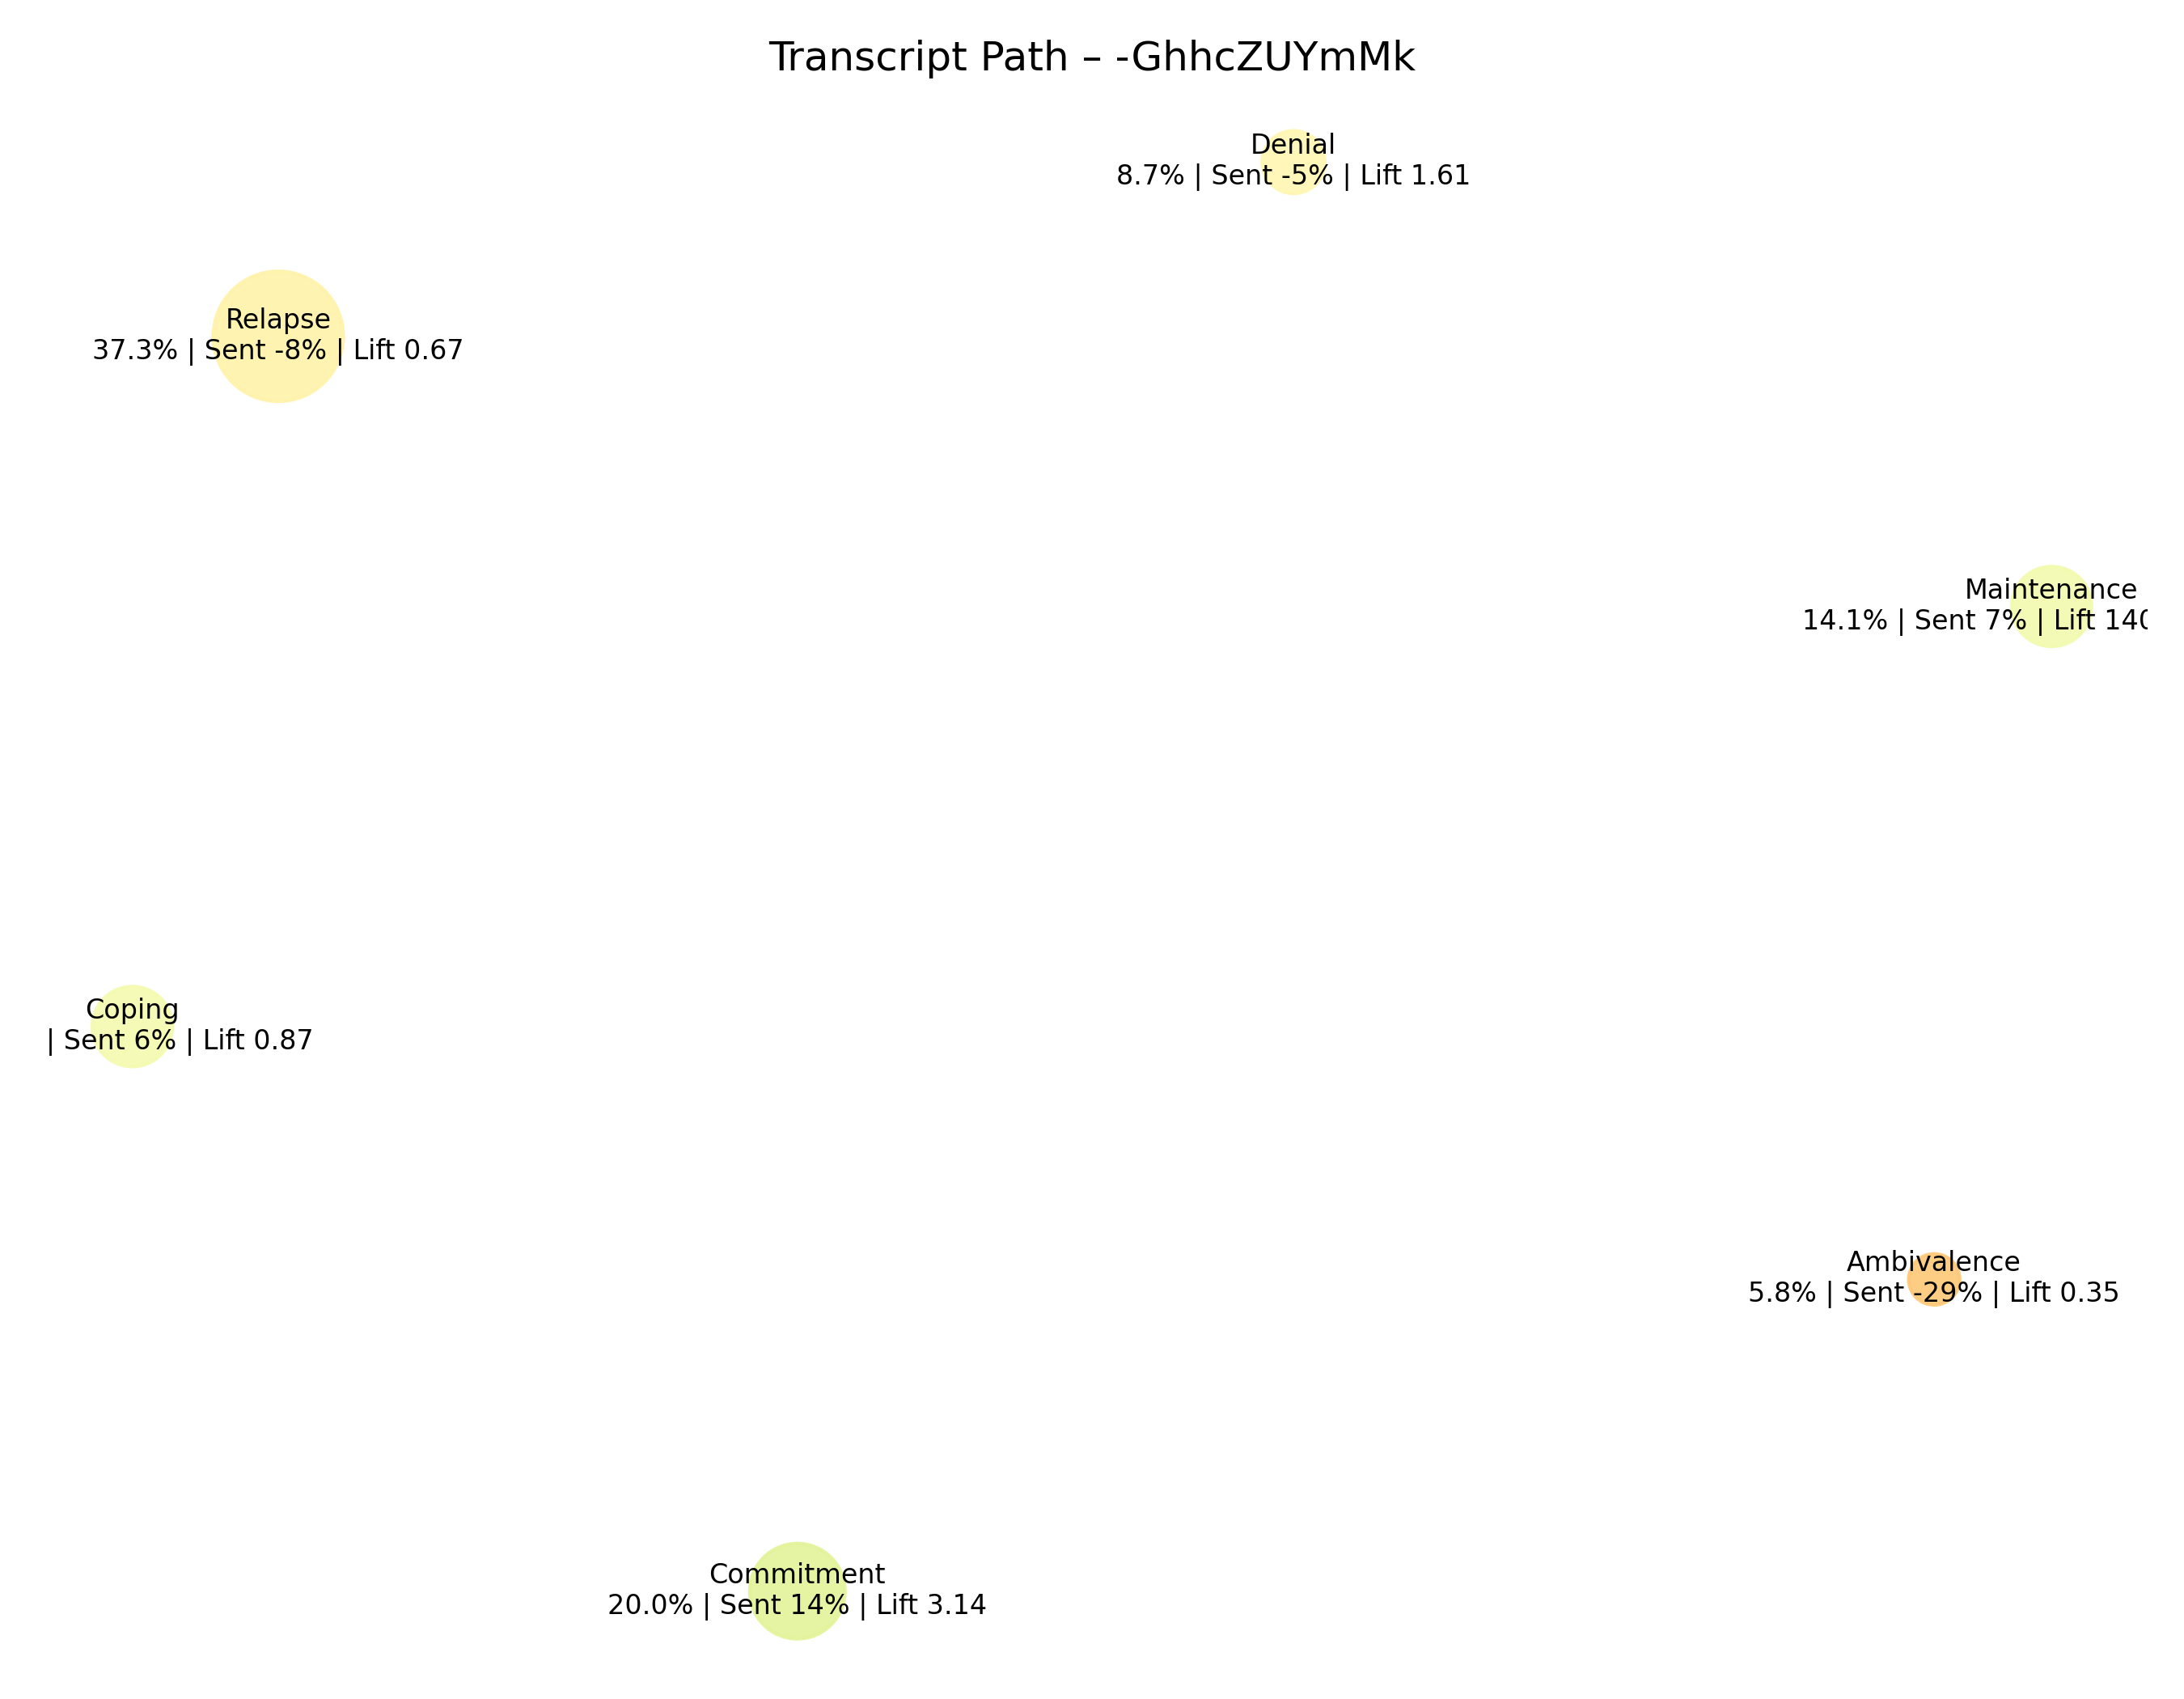

🎧 Audio Path Mind-Map:


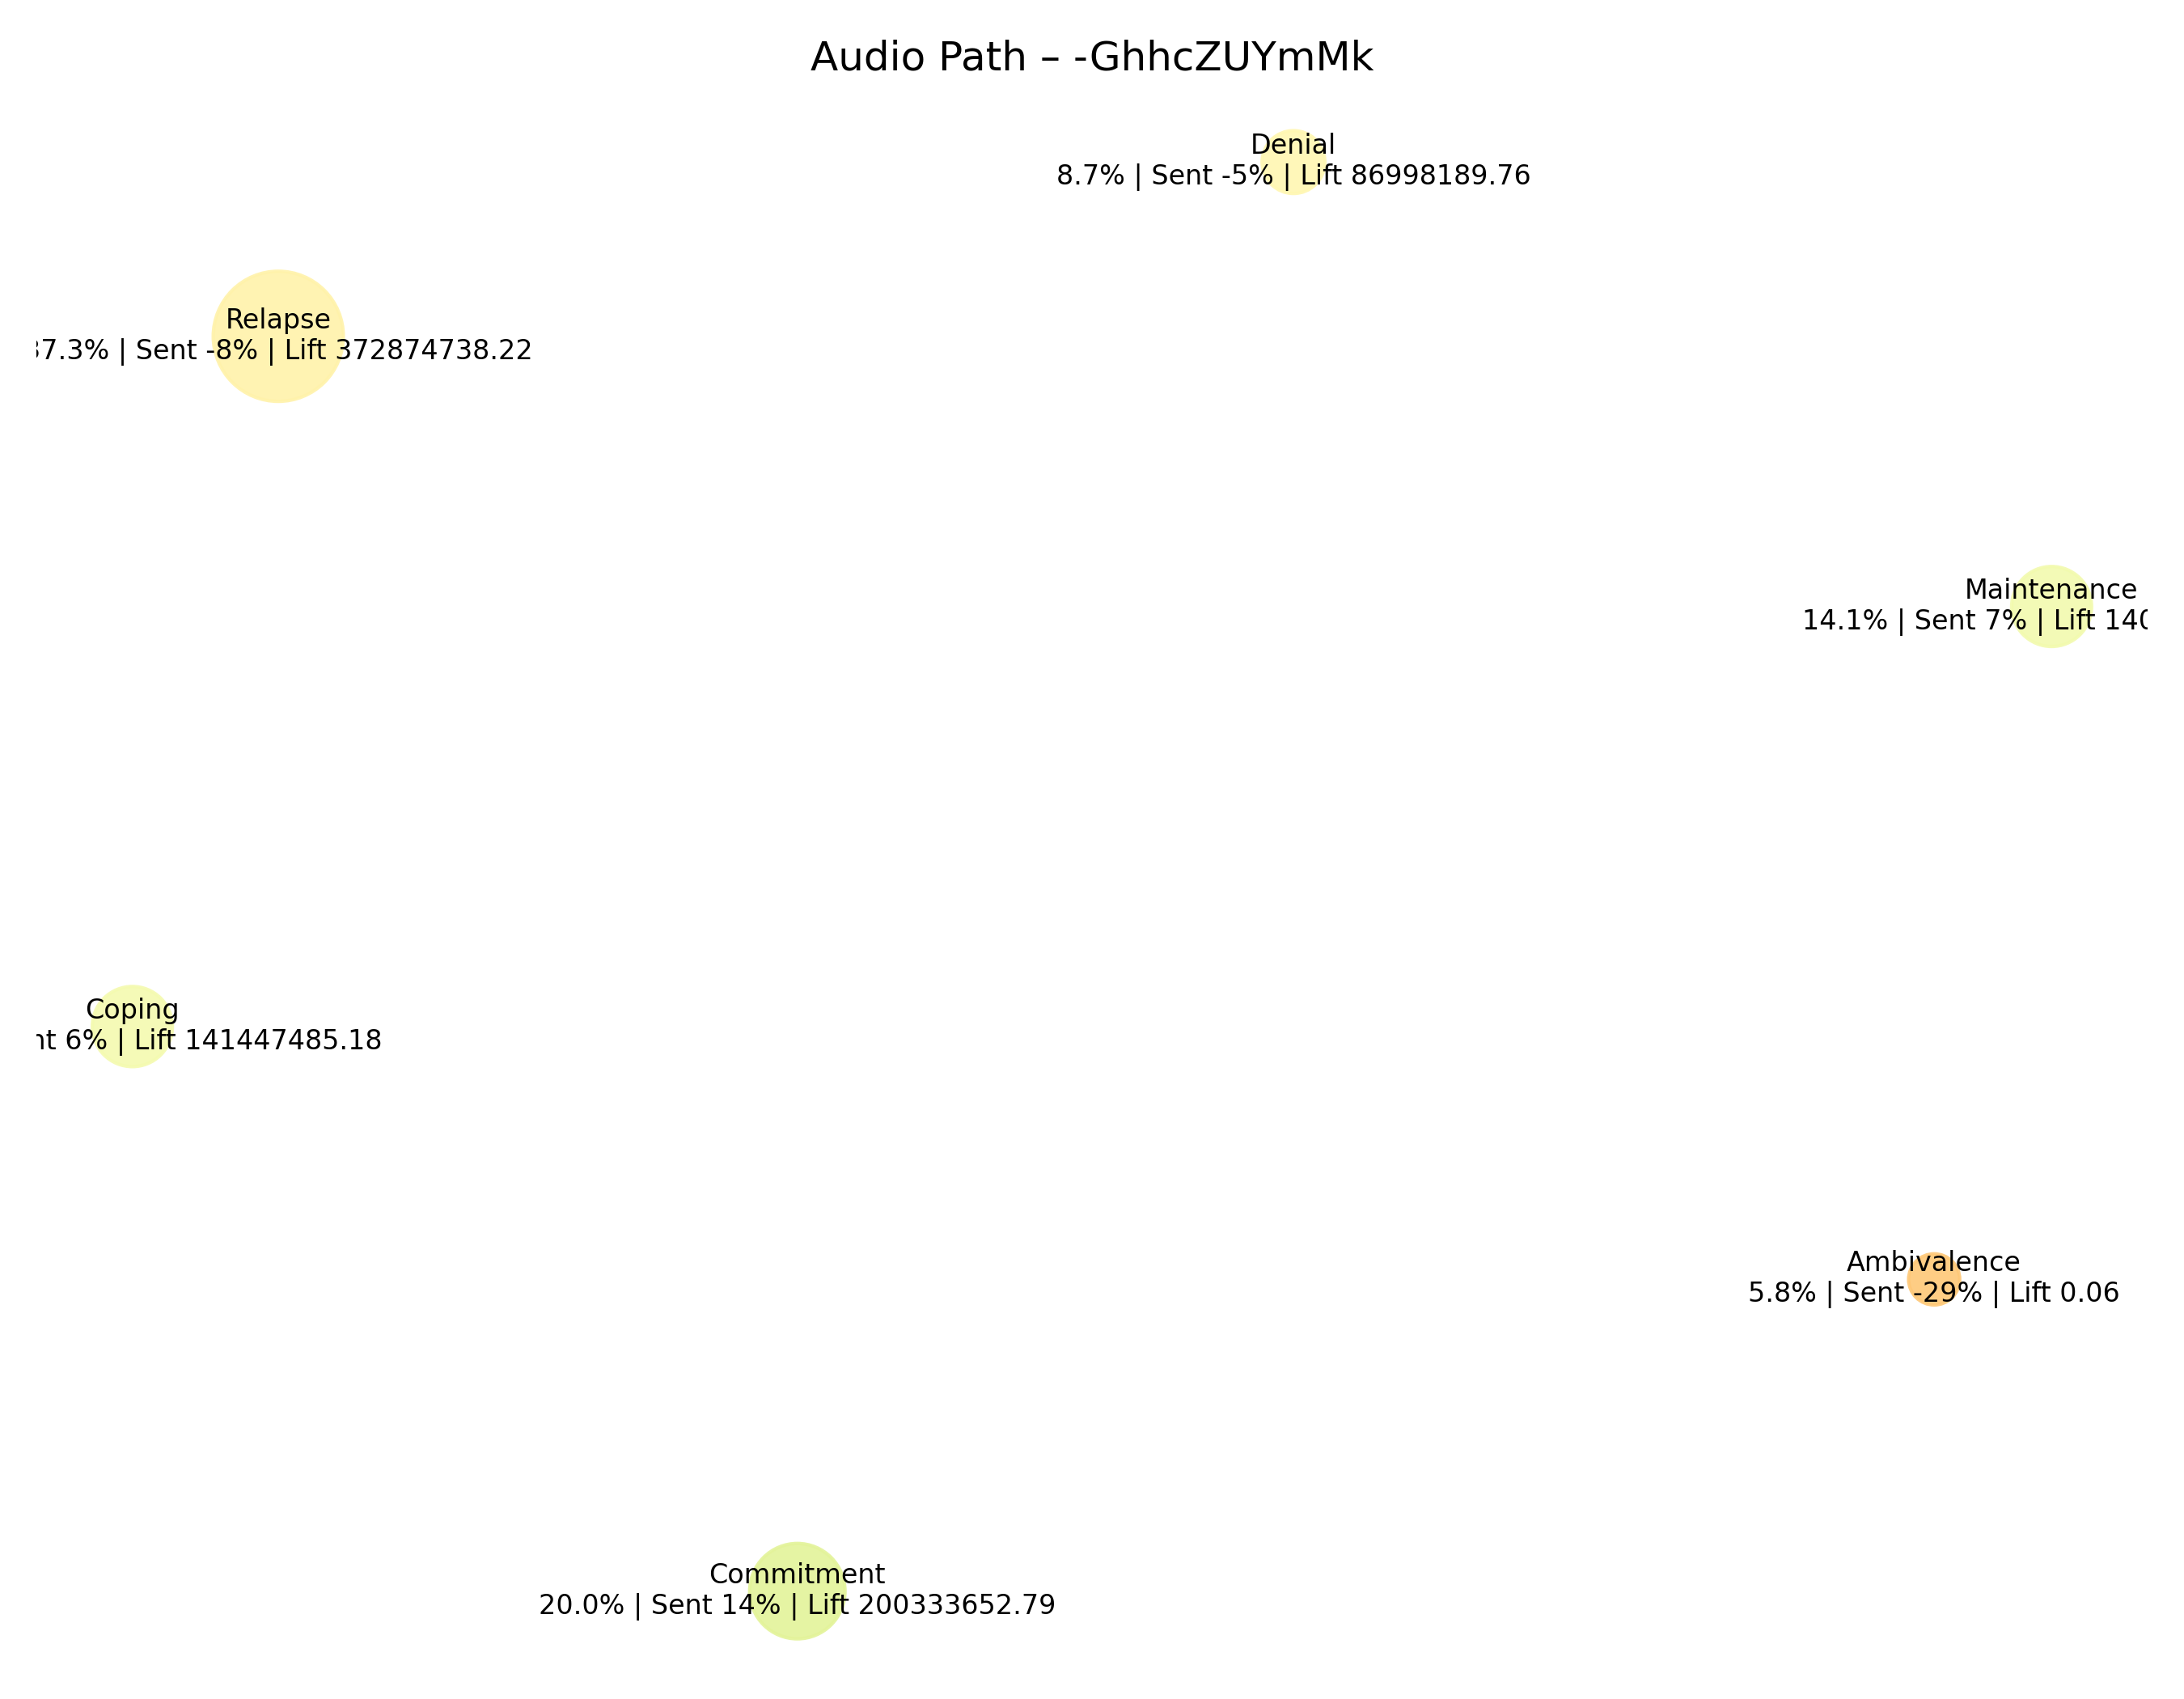

In [14]:
# -------------------------------------------------------------
# Demo run on the first audio file (optional)
# -------------------------------------------------------------

audio_files = sorted(glob.glob(str(AUDIO_DIR / "*.m4a")))
if len(audio_files) > 0:
    test_audio = Path(audio_files[0])
    print(f"\n🎬 Running demo on first audio file: {test_audio.name}")

    try:
        demo_summary = recommend_recovery_path(test_audio)
    except Exception as e:
        print(f"❌ Demo run failed: {e}")
    else:
        print("\n✅ Demo run finished successfully!")
        print("📈 Metrics:")
        for k, v in demo_summary["metrics"].items():
            print(f"   {k}: {v:.3f}")
        print("🚦 On-track status:", demo_summary["on_track"])

        # --- Display the resulting mind-map images inline ---
        from PIL import Image
        import IPython.display as ipd

        try:
            img_text  = Image.open(demo_summary["outputs"]["text_mindmap_png"])
            img_audio = Image.open(demo_summary["outputs"]["audio_mindmap_png"])

            print("\n🧾 Transcript Path Mind-Map:")
            ipd.display(img_text)
            print("🎧 Audio Path Mind-Map:")
            ipd.display(img_audio)
        except Exception:
            print("(Unable to render mind-map images inline.)")
else:
    print("⚠️ No audio files found in the dataset folder.")


#### Helper Cell — Upload or Pick a New Audio Clip and Run the Recommender Automatically

This cell:
1. Opens a file-picker window (inside Jupyter) to select any new `.m4a`, `.wav`, or `.mp3` audio clip.
2. Automatically runs `recommend_recovery_path()` on the selected clip.
3. Displays:
   - The key metrics (JSD vs baseline, alignment, on-track status)
   - The generated Transcript and Audio mind-map images inline.


**THE BELOW CELL SHOULD BE UNCOMMENTED AND RUN ONLY IF THERE IS AN APPROPRIATE AUDIO CLIP FILE AVAILABLE**

In [ ]:
# from tkinter import Tk, filedialog
# import IPython.display as ipd
# from PIL import Image

# # ----------------------------------------------
# # Step 1. File picker — select new audio clip
# # ----------------------------------------------
# Tk().withdraw()  # hide the root Tkinter window
# file_path = filedialog.askopenfilename(
#     title="Select an audio file to analyze",
#     filetypes=[("Audio files", "*.m4a *.wav *.mp3 *.flac *.ogg *.wma"), ("All files", "*.*")]
# )

# if not file_path:
#     print("❌ No file selected. Please choose an audio clip.")
# else:
#     new_audio = Path(file_path)
#     print(f"\n🎵 Selected file: {new_audio.name}")

#     # Quick in-notebook audio playback (if supported)
#     try:
#         ipd.display(ipd.Audio(str(new_audio)))
#     except Exception:
#         print("(Preview not available — continuing...)")

#     # ----------------------------------------------
#     # Step 2. Safety check — ensure baselines exist
#     # ----------------------------------------------
#     global_text_json  = MINDMAP_DIR / "global_text_path.json"
#     global_audio_json = MINDMAP_DIR / "global_audio_path.json"

#     if not (global_text_json.exists() and global_audio_json.exists()):
#         print("⚠️ Global baselines not found.")
#         print("Please run the Global Mind-Maps Cell (Cell E) first.")
#     else:
#         # ----------------------------------------------
#         # Step 3. Run recommender
#         # ----------------------------------------------
#         try:
#             summary = recommend_recovery_path(new_audio)
#         except Exception as e:
#             print(f"❌ Error during analysis: {e}")
#         else:
#             print("\n✅ Analysis complete!")
#             print("📈 Metrics:")
#             for k, v in summary["metrics"].items():
#                 print(f"   {k}: {v:.3f}")
#             print("🚦 On-track status:", summary["on_track"])

#             # ----------------------------------------------
#             # Step 4. Display resulting mind-map images
#             # ----------------------------------------------
#             try:
#                 img_text  = Image.open(summary["outputs"]["text_mindmap_png"])
#                 img_audio = Image.open(summary["outputs"]["audio_mindmap_png"])

#                 print("\n🧾 Transcript Path Mind-Map:")
#                 ipd.display(img_text)
#                 print("🎧 Audio Path Mind-Map:")
#                 ipd.display(img_audio)
#             except Exception:
#                 print("(Unable to render mind-map images inline.)")


### Cell H — Ethics & Safety

- **Not for diagnosis or treatment.** This is an analytical recommender aimed at *patterns*, not a clinical instrument.
- **Bias**: Speech emotion recognition and topic models can reflect accent, gender, or cultural biases. Evaluate by subgroup and calibrate thresholds.
- **Consent & privacy**: Use only consented, public data. Strip any PII. Store embeddings/aggregates when possible, not raw audio/text.
- **Human-in-the-loop**: Always keep a qualified reviewer in the loop for decisions that could affect care.


# THE END